### Compute the bias of CHIRPS-GEFS's 5 day forecast

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import datetime
from datetime import timedelta
import re
import seaborn as sns
import calendar
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [7]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip,plot_spatial_columns

#### Set config values

In [8]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
dry_spells_processed_dir=os.path.join(country_data_processed_dir,"dry_spells")
chirpsgefs_processed_dir = os.path.join(dry_spells_processed_dir,"chirpsgefs")

#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
chirpsgefs_stats_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [9]:
days_ahead=5

In [10]:
if days_ahead==5:
    chirpsgefs_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back_adm2_5day.csv")
    chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long_5day.csv")
elif days_ahead==15:
    chirpsgefs_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
    chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long.csv")

In [11]:
#ccontains several statistics per adm2-date combination since 2000
df_cg_fd=pd.read_csv(chirpsgefs_path)
df_cg_fd["date"]=pd.to_datetime(df_cg_fd["date"])
#date_forec_end is not correct!! didn't adjust correctly in computation script
df_cg_fd["date_forec_end"]=df_cg_fd.date+timedelta(days=days_ahead-1)
# df_cg_fd["date_forec_end"]=pd.to_datetime(df_cg_fd["date_forec_end"])

In [12]:
# df_bound_adm2=gpd.read_file(adm2_bound_path)

In [13]:
#read historically observed 15 day rolling sum for all dates (so not only those with dry spells), derived from CHIRPS
#this sometimes gives a not permitted error --> move the chirps_rolling_sum_path file out of the folder and back in to get it to work (dont ask me why)
df_histobs=pd.read_csv(chirps_rolling_sum_path)
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=days_ahead-1)

#add adm2 and adm1 name
# df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [14]:
df_histobs

,ID,pcode,date,total_prec,year,month,day,season_approx,rollsum_5d,rollsum_10d,rollsum_14d,rollsum_15d,rollsum_15d_back,rainy_day_bin,rainy_day_bin_2mm,date_start
0,6,MW101,2000-01-01,2.391468,2000,1,1,1999,NaN,NaN,NaN,NaN,107.775147,0,1,1999-12-28
1,6,MW101,2000-01-02,11.620306,2000,1,2,1999,NaN,NaN,NaN,NaN,111.956002,1,1,1999-12-29
2,6,MW101,2000-01-03,2.493552,2000,1,3,1999,NaN,NaN,NaN,NaN,106.921301,0,1,1999-12-30
3,6,MW101,2000-01-04,7.696035,2000,1,4,1999,NaN,NaN,NaN,NaN,105.523829,1,1,1999-12-31
4,6,MW101,2000-01-05,5.079418,2000,1,5,1999,29.280778,NaN,NaN,NaN,103.182020,1,1,2000-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245467,3,MW315,2020-12-27,0.624972,2020,12,27,2020,15.348300,25.72296,48.25467,55.76131,NaN,0,0,2020-12-23
245468,3,MW315,2020-12-28,0.000000,2020,12,28,2020,15.348300,25.72296,44.13408,48.25467,NaN,0,0,2020-12-24
245469,3,MW315,2020-12-29,2.532722,2020,12,29,2020,13.166970,25.73795,44.84287,46.66680,NaN,0,1,2020-12-25
245470,3,MW315,2020-12-30,8.031535,2020,12,30,2020,13.221920,25.91256,42.39850,52.87440,NaN,1,1,2020-12-26


In [15]:
#merge forecast and observed
#only include dates that have a forecast, i.e. merge on right
#date in df_chirpsgefs is the first date of the forecast
#so the values are the rolling sum for the date+timedelta(t=days_ahead) #where days_aheas is 5 in this case
df_histformerg=df_histobs.merge(df_cg_fd,how="right",left_on=["date_start","pcode"],right_on=["date","ADM2_PCODE"],suffixes=("obs","forec"))

In [16]:
df_histformerg["diff_forecobs"]=df_histformerg["mean_cell"]-df_histformerg[f"rollsum_{days_ahead}d"]

In [17]:
df_histformerg.diff_forecobs.median()

4.359254184988355

In [18]:

df_histformerg[["dateforec","dateobs","diff_forecobs","mean_cell","rollsum_15d"]] #,"rollsum_5d"

,dateforec,dateobs,diff_forecobs,mean_cell,rollsum_15d
0,2000-01-01,2000-01-05,-4.113510,11.300500,NaN
1,2000-01-02,2000-01-06,-6.926617,13.243983,NaN
2,2000-01-03,2000-01-07,9.417646,20.851776,NaN
3,2000-01-04,2000-01-08,6.726212,29.193962,NaN
4,2000-01-05,2000-01-09,-29.647497,23.555213,NaN
...,...,...,...,...,...
77563,2021-04-01,NaT,NaN,5.925734,NaN
77564,2021-04-02,NaT,NaN,6.100202,NaN
77565,2021-04-03,NaT,NaN,1.928683,NaN
77566,2021-04-04,NaT,NaN,7.851199,NaN


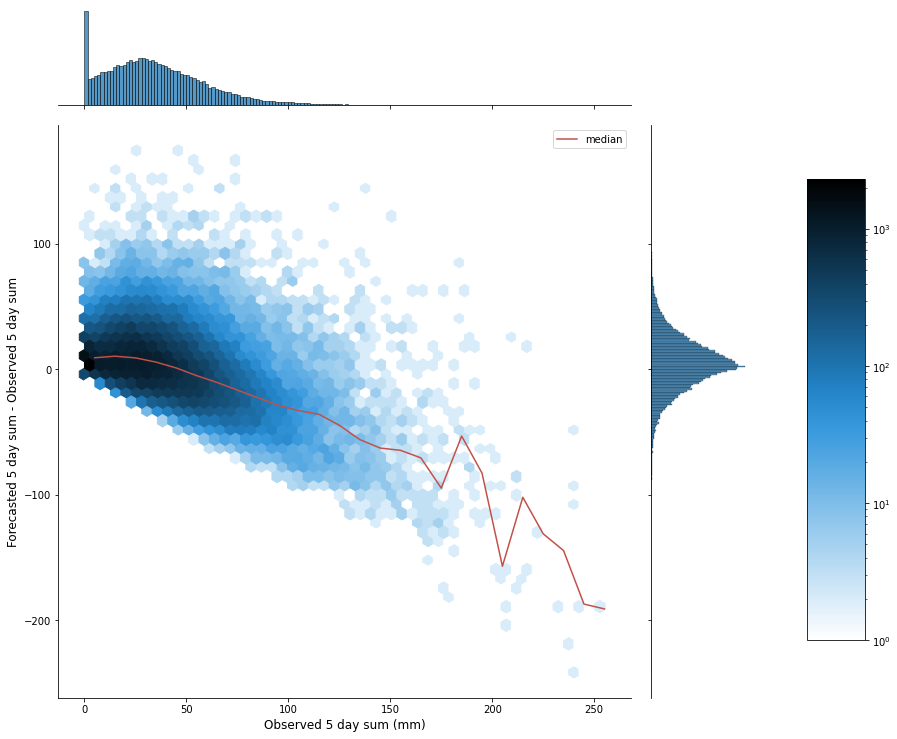

In [19]:
#plot the observed vs forecast-observed to get a feeling for the discrepancy between the two
g=sns.jointplot(data=df_histformerg,y="diff_forecobs",x=f"rollsum_{days_ahead}d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_histformerg[f"rollsum_{days_ahead}d"].max()+20,10)
group = df_histformerg.groupby(pd.cut(df_histformerg[f"rollsum_{days_ahead}d"], bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="median")
g.set_axis_labels(f"Observed {days_ahead} day sum (mm)", f"Forecasted {days_ahead} day sum - Observed {days_ahead} day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells",f"plot_MWI_chirpsgefs_{days_ahead}days_density.png"))

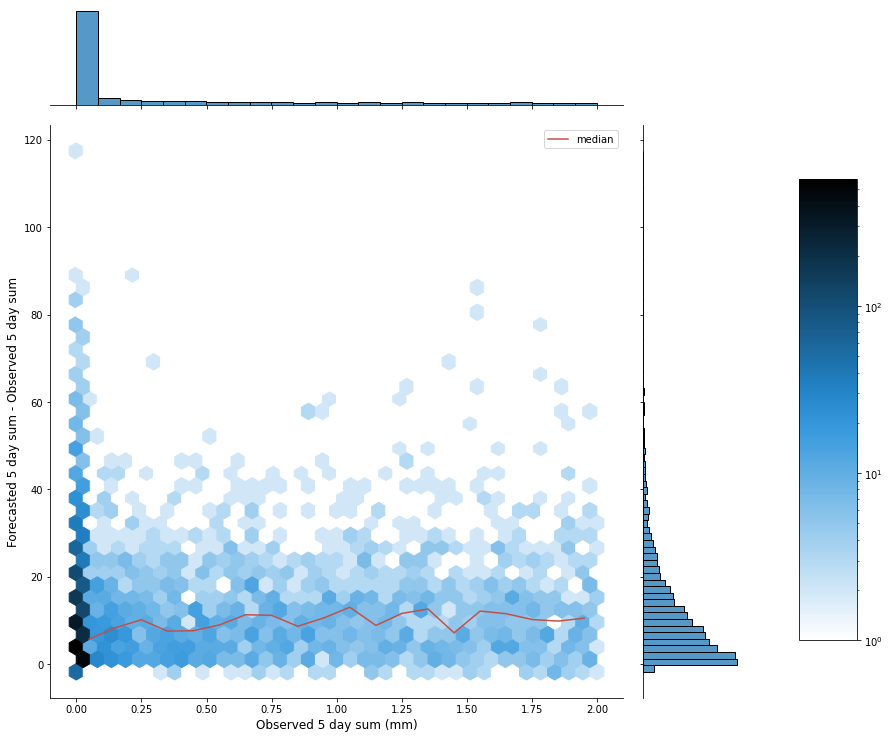

In [20]:
#plot the observed vs forecast-observed for obs<=2mm
df_sel=df_histformerg[df_histformerg[f"rollsum_{days_ahead}d"]<=2].sort_values(f"rollsum_{days_ahead}d")
g=sns.jointplot(data=df_sel,y="diff_forecobs",x=f"rollsum_{days_ahead}d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_sel[f"rollsum_{days_ahead}d"].max()+20,0.1)
group = df_sel.groupby(pd.cut(df_sel[f"rollsum_{days_ahead}d"], bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="median")
g.set_axis_labels(f"Observed {days_ahead} day sum (mm)", f"Forecasted {days_ahead} day sum - Observed {days_ahead} day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density.png"))

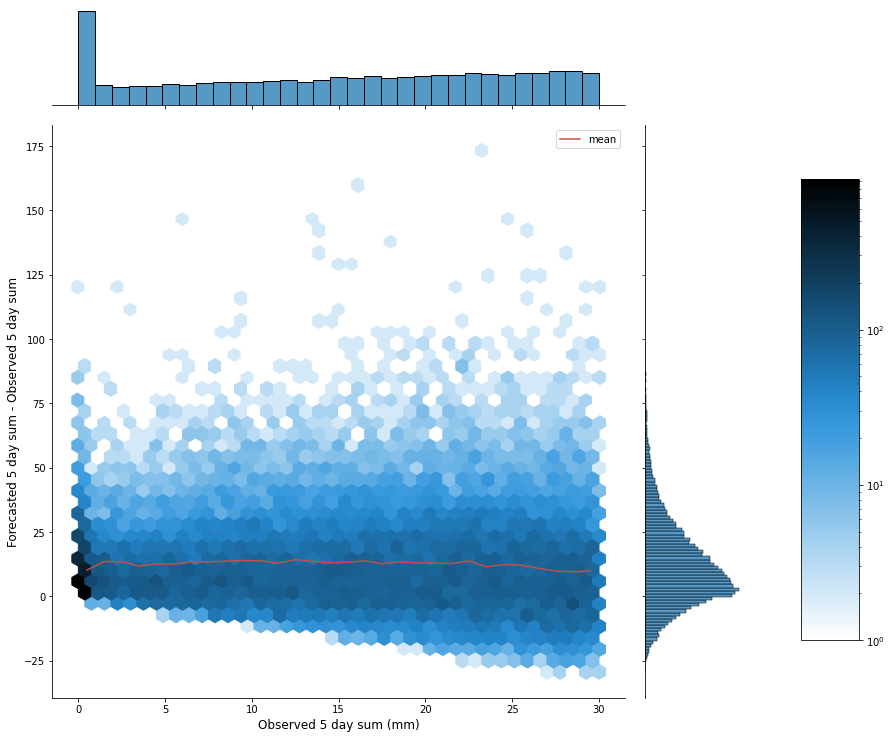

In [21]:
#plot the observed vs forecast-observed for obs<=2mm
df_sel=df_histformerg[df_histformerg[f"rollsum_{days_ahead}d"]<=30].sort_values(f"rollsum_{days_ahead}d")
g=sns.jointplot(data=df_sel,y="diff_forecobs",x=f"rollsum_{days_ahead}d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_sel[f"rollsum_{days_ahead}d"].max()+20,1)
group = df_sel.groupby(pd.cut(df_sel[f"rollsum_{days_ahead}d"], bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.mean()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="mean")
g.set_axis_labels(f"Observed {days_ahead} day sum (mm)", f"Forecasted {days_ahead} day sum - Observed {days_ahead} day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density.png"))

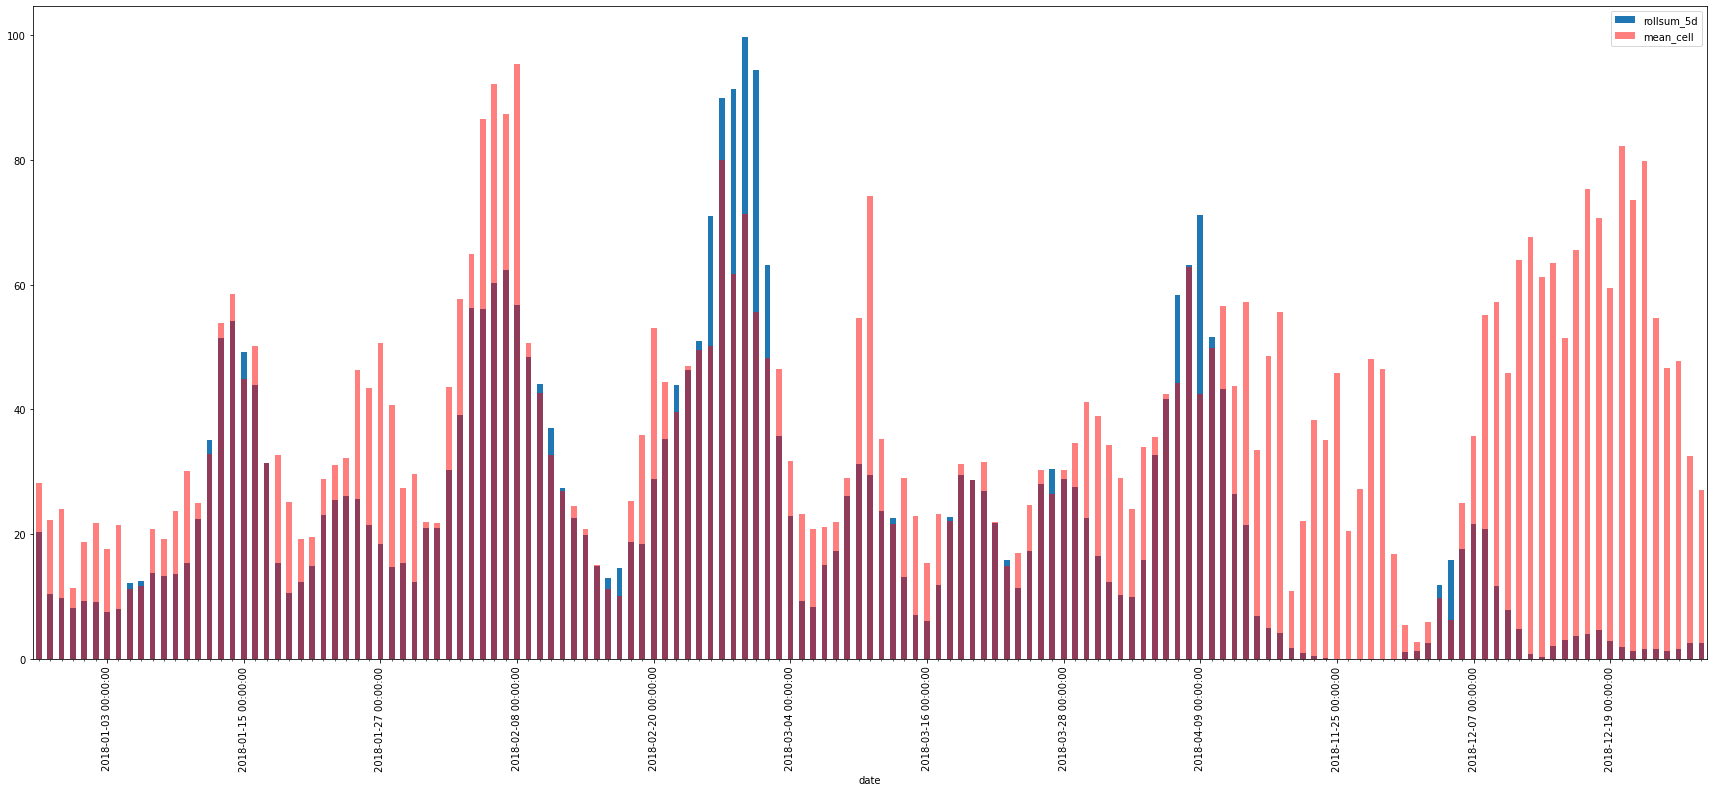

In [22]:
from matplotlib.ticker import StrMethodFormatter
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(30,12))
df_histobs[(df_histobs.date.dt.year==2018)].groupby("date_start",as_index=False).mean().sort_values(by="date_start").plot.bar(x="date_start",y=f"rollsum_{days_ahead}d",ax=ax)
df_cg_fd[(df_cg_fd.date_forec_end.dt.year==2018)].groupby("date",as_index=False).mean().sort_values(by="date").plot.bar(x="date",y="mean_cell",ax=ax,alpha=0.5,color="red")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=12))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))